In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/ARDL

/content/drive/MyDrive/Github/ARDL


In [ ]:
%load_ext autoreload
%autoreload 2

from dataset import *
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')


In [ ]:
emb_mat, data = create_inp_data_and_weights(newsgroups_train, newsgroups_test, glove_dim=50)

Vocabulary size [Bag-of-words]:  151353
Vocabulary size [GloVe]:  400000


In [ ]:
from dnn import *
input_size, emb_size = emb_mat.shape
model = build_random_dnn(input_size, emb_size, emb_mat, 1, 6, 128, 600, 7)

model

DNN(
  (embedding): Embedding(151353, 50)
  (fc1): Linear(in_features=25000, out_features=392, bias=True)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden): ModuleList(
    (0): Linear(in_features=392, out_features=494, bias=True)
    (1): Linear(in_features=494, out_features=429, bias=True)
    (2): Linear(in_features=429, out_features=527, bias=True)
  )
  (fc2): Linear(in_features=527, out_features=7, bias=True)
  (bn2): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (att): Linear(in_features=527, out_features=7, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# learning_rate = 0.001
# num_epochs = 30
# batch_size = 512
# display_step = 4
learning_rate = 0.00001
num_epochs = 70
batch_size = 512
display_step = 4
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [ ]:
from torch.autograd import Variable

In [ ]:
# training_loss = []
# validation_loss = []
total_batch = int(len(newsgroups_train.data)/batch_size)
    
total_batch_val = int(len(newsgroups_test.data)/batch_size)
    
model = model.to(device)
for epoch in range(num_epochs):
    tr_loss = []
    model.train()

    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(data['train'],i,batch_size)

        articles = Variable(torch.LongTensor(batch_x)).to(device)
        labels = Variable(torch.LongTensor(batch_y)).to(device)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        _, outputs = model(articles)
        #print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        tr_loss.append(loss.data)
        if (i+1) % display_step == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(newsgroups_train.data)//batch_size, loss.data))    
    
    model.eval()
    training_loss.append(sum(tr_loss)/total_batch)

    model.eval()
    # Loop over all batches
    batch_val_loss = []
    for i in range(total_batch_val):
        
        batch_x,batch_y = get_batch(data['test'],i,batch_size)

        articles = Variable(torch.LongTensor(batch_x)).to(device)
        labels = Variable(torch.LongTensor(batch_y)).to(device)

        _, y_test_pred = model(articles)
        
        test_loss = criterion(y_test_pred, labels)
        batch_val_loss.append(test_loss.data)

    validation_loss.append(sum(batch_val_loss)/total_batch_val)

/content/drive/MyDrive/Github/ARDL/dnn.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)


Epoch [1/17], Step [4/22], Loss: 0.6888
Epoch [1/17], Step [8/22], Loss: 0.6785
Epoch [1/17], Step [12/22], Loss: 0.6491
Epoch [1/17], Step [16/22], Loss: 0.6459
Epoch [1/17], Step [20/22], Loss: 0.6587
Epoch [2/17], Step [4/22], Loss: 0.6798
Epoch [2/17], Step [8/22], Loss: 0.6726
Epoch [2/17], Step [12/22], Loss: 0.6533
Epoch [2/17], Step [16/22], Loss: 0.6557
Epoch [2/17], Step [20/22], Loss: 0.6699
Epoch [3/17], Step [4/22], Loss: 0.6871
Epoch [3/17], Step [8/22], Loss: 0.6503
Epoch [3/17], Step [12/22], Loss: 0.6428
Epoch [3/17], Step [16/22], Loss: 0.6403
Epoch [3/17], Step [20/22], Loss: 0.6417
Epoch [4/17], Step [4/22], Loss: 0.6651
Epoch [4/17], Step [8/22], Loss: 0.6421
Epoch [4/17], Step [12/22], Loss: 0.6457
Epoch [4/17], Step [16/22], Loss: 0.6412
Epoch [4/17], Step [20/22], Loss: 0.6547
Epoch [5/17], Step [4/22], Loss: 0.6626
Epoch [5/17], Step [8/22], Loss: 0.6343
Epoch [5/17], Step [12/22], Loss: 0.6259
Epoch [5/17], Step [16/22], Loss: 0.6129
Epoch [5/17], Step [20/22]

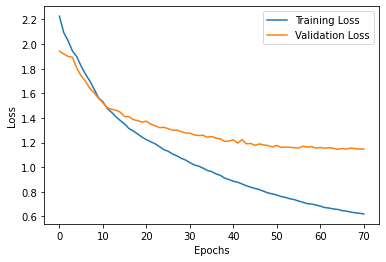

In [ ]:
folder_name = 'models/dnn/model_2_11_03/'

from matplotlib import pyplot as plt
# training_loss = np.array(training_loss)
# validation_loss = np.array(validation_loss)

for i in range(len(training_loss)):
  training_loss[i] = training_loss[i].cpu()

for i in range(len(validation_loss)):
  validation_loss[i] = validation_loss[i].cpu()

training_loss_ = np.array(training_loss)
validation_loss_ = np.array(validation_loss)


fig = plt.figure()
plt.plot(training_loss_)
plt.plot(validation_loss_)
plt.legend(["Training Loss", "Validation Loss"])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()
fig.savefig(folder_name + 'loss_vs_epoch.png')

In [ ]:
total_batch = int(len(newsgroups_test.data)/batch_size)
correct = 0
total = 0
# Loop over all batches
for i in range(total_batch):
    batch_x,batch_y = get_batch(data['test'],i,batch_size)

    articles = Variable(torch.LongTensor(batch_x)).to(device)
    labels = Variable(torch.LongTensor(batch_y)).to(device)

    # Final validation accuracy
    total, correct = 0, 0
    model.eval()
    _, y_test_pred = model(articles)
    predicted = torch.argmax(y_test_pred, 1)

    total += y_test_pred.size(0)

    correct += (predicted == labels).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

/content/drive/MyDrive/Github/ARDL/dnn.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)


Accuracy of the model is: 68.95%


In [ ]:
# Additional information
PATH = folder_name + "model.pt"
LOSS = 0.6182
ACCURACY = 68.95

# Store model
torch.save({
            'accuracy': ACCURACY,
            'epoch': num_epochs,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

# Store model architecture
import pickle
file_name = folder_name + 'model_architecture.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(model, f)